In [11]:
"""
This file contains a toy version of the probability graph building algorithm.
"""
import numpy as np
from scipy.special import logsumexp
from queue import Queue
from collections import defaultdict, Counter
from itertools import product
import networkx as nx
import matplotlib.pyplot as plt
import random


class GroundTruthModel:
    def __init__(self):
        self.states = [
            "question",
            "step 1, wording 1",
            "step 1, wording 2",
            "step 2, wording 1",
            "step 2, wording 2",
            "step 3, wording 1",
            "step 3, wording 2",
            "right answer, wording 1",
            "right answer, wording 2",
            "wrong answer",
        ]

    def get_next_state_distribution(self, path: tuple):
        """
        Define some toy dynamics over different reasoning traces.
        """
        unnormalized_probs = np.zeros(len(self.states))
        # if we've finished the problem, return an invalid distribution

        last_state_abstract = path[-1].split(",")[0] if "," in path[-1] else path[-1]
        if last_state_abstract in ("right answer", "wrong answer"):
            return unnormalized_probs

        unnormalized_probs[self.states.index("right answer, wording 1")] = 1
        unnormalized_probs[self.states.index("right answer, wording 2")] = 1
        unnormalized_probs[self.states.index("wrong answer")] = 2
        if last_state_abstract == "step 3":
            unnormalized_probs[self.states.index("right answer, wording 1")] = 5
            unnormalized_probs[self.states.index("right answer, wording 2")] = 5
        elif last_state_abstract in ("step 1", "step 2"):
            unnormalized_probs[self.states.index("step 3, wording 1")] = 1
            unnormalized_probs[self.states.index("step 3, wording 2")] = 10
        elif last_state_abstract == "question":
            unnormalized_probs[self.states.index("step 1, wording 1")] = 5
            unnormalized_probs[self.states.index("step 1, wording 2")] = 5
            unnormalized_probs[self.states.index("step 2, wording 1")] = 5
            unnormalized_probs[self.states.index("step 2, wording 2")] = 5

        probs = unnormalized_probs / np.sum(unnormalized_probs)
        return probs

    def sample(self, prompts):
        """
        Generate the next step given a partial path.
        """
        responses = []
        for prompt in prompts:
            next_state_dist = self.get_next_state_distribution(prompt)
            if sum(next_state_dist) == 0:
                responses.append("<eos>")
            else:
                next_state = np.random.choice(self.states, p=next_state_dist)
                responses.append(next_state)

        return responses

    def score(self, paths):
        """
        Get the log probs of each step along the paths.
        """
        scores = []
        for path in paths:
            score = 0
            for i in range(1, len(path)):
                score += np.log(
                    self.get_next_state_distribution(path[:i])[
                        self.states.index(path[i])
                    ]
                )
            scores.append(score)
        return scores


def is_paraphrase(s1, s2):
    """ """
    return s1 == s2 or s1.split(",")[0] == s2.split(",")[0]


def get_equivalence_classes(paths):
    """
    This function will be a lot more involved when working with LLMs
    """
    equivalence_classes = defaultdict(Counter)
    for path in paths:
        last_state = path[-1]
        if last_state == "<eos>":
            continue
        last_state_abstract = (
            last_state.split(",")[0] if "," in last_state else last_state
        )
        equivalence_classes[last_state_abstract].update([path])
    print(equivalence_classes)
    return equivalence_classes


def sample_paths(path_counter, n_samples):
    """
    Sample from a path counter
    """
    return random.choices(
        list(path_counter.keys()), weights=list(path_counter.values()), k=n_samples
    )


def update_equivalence_classes(equivalence_classes, new_classes):
    """
    Update the set of equivalence classes with the newly-discovered ones
    """
    for new_class in new_classes:
        if new_class in equivalence_classes:
            equivalence_classes[new_class] += new_classes[new_class]
        else:
            equivalence_classes[new_class] = new_classes[new_class]

    return equivalence_classes


def get_all_transitions(model, n_samples=100):
    """
    Build a graph of the probability of each state given the previous state.
    """
    # keep track of the paths that end in each equivalence class
    all_equivalence_classes = {"question": Counter([("question",)])}
    # track the equivalence classes that we discovered in the last step
    new_equivalence_classes = list(all_equivalence_classes.keys())
    # track the different wordings we find that make up each equivalence class
    unique_wordings = defaultdict(set)
    unique_wordings["question"] = {"question"}

    while True:
        # reset the new equivalence classes
        prev_equivalence_classes = new_equivalence_classes
        new_equivalence_classes = []

        # sample paths from each existing equivalence class
        # (this should be batched if we're using a transformer)
        for class_name in prev_equivalence_classes:
            # sample some paths that lead to the new equivalence class
            paths = sample_paths(all_equivalence_classes[class_name], n_samples)

            for path in paths:
                # sample completions from the model to get the next step following the path
                completions = model.sample([path] * n_samples)
                new_paths = [path + (completion,) for completion in completions]

                # group the completions into equivalence classes
                completion_classes = get_equivalence_classes(new_paths)

                # Update our data structures
                # I think it's ok for this kind of thing to be in a for loop,
                # as each operation won't take much time
                for completion_class in completion_classes:
                    if completion_class not in all_equivalence_classes:
                        new_equivalence_classes.append(completion_class)
                    unique_wordings[completion_class].update(
                        [x[-1] for x in completion_classes[completion_class].keys()]
                    )
                # update the running tracker of all discovered euqivalence classes
                all_equivalence_classes = update_equivalence_classes(
                    all_equivalence_classes, completion_classes
                )

        # break when we stop discovering new equivalence classes
        if len(new_equivalence_classes) == 0:
            break

    return all_equivalence_classes, unique_wordings


def build_probabilistic_graph(classes, class_phrasings, model, n_samples):
    """
    Build a graph of the probability of transitioning from one state to another.
    """

    weighted_transitions = []

    # iterate over pairs of equivalence classes
    # NOTE: right now we're iterating over all possible classes. We could speed things up
    # by keeping track of the pairs of classes that were observed at least one in step 1
    for first_state in classes:
        for second_state in classes:
            # compute the probability of transitioning from first state to second state
            first_state_paths = sample_paths(classes[first_state], n_samples)

            # sum over phrasings of the second state.
            # This will most likely need to be batched
            all_logps_c2_given_s1 = []
            for s1_path in first_state_paths:
                # score the possible completions
                logps_s1_and_s2 = model.score(
                    [
                        s1_path + (s2_phrasing,)
                        for s2_phrasing in class_phrasings[second_state]
                    ]
                )
                # filter out -inf values
                logps_s1_and_s2 = np.array([p for p in logps_s1_and_s2 if p != -np.inf])
                if len(logps_s1_and_s2) == 0:
                    continue
                # subtract the probability of all but the last step to get the conditional probability
                logp_s1 = model.score([s1_path])[0]
                logps_s2_given_s1 = np.array(logps_s1_and_s2) - np.array(logp_s1)

                # sum over conditional probabilities for this equivalence class
                logp_c2_given_s1 = logsumexp(logps_s2_given_s1)
                all_logps_c2_given_s1.append(logp_c2_given_s1)
            
            # skip if the probability of going from first_state to second_state is 0
            if len(all_logps_c2_given_s1) == 0:
                continue

            # average over the samples to get the log prob estimate
            logp_c2_given_c1 = logsumexp(all_logps_c2_given_s1) - np.log(n_samples)

            weighted_transitions.append(
                (first_state, second_state, np.round(logp_c2_given_c1, 2))
            )

    # make a directed graph weighted by probabilities
    G = nx.DiGraph()
    G.add_weighted_edges_from(weighted_transitions)
    return G

In [7]:
print(nx.__version__)

3.3


defaultdict(<class 'collections.Counter'>, {'step 1': Counter({('question', 'step 1, wording 2'): 23, ('question', 'step 1, wording 1'): 17}), 'step 2': Counter({('question', 'step 2, wording 2'): 24, ('question', 'step 2, wording 1'): 21}), 'right answer': Counter({('question', 'right answer, wording 2'): 6, ('question', 'right answer, wording 1'): 3}), 'wrong answer': Counter({('question', 'wrong answer'): 6})})
defaultdict(<class 'collections.Counter'>, {'step 2': Counter({('question', 'step 2, wording 1'): 23, ('question', 'step 2, wording 2'): 12}), 'step 1': Counter({('question', 'step 1, wording 2'): 30, ('question', 'step 1, wording 1'): 17}), 'wrong answer': Counter({('question', 'wrong answer'): 9}), 'right answer': Counter({('question', 'right answer, wording 1'): 6, ('question', 'right answer, wording 2'): 3})})
defaultdict(<class 'collections.Counter'>, {'wrong answer': Counter({('question', 'wrong answer'): 6}), 'step 2': Counter({('question', 'step 2, wording 1'): 26, ('

/tmp/user/22947/ipykernel_3274935/1305524327.py:81: RuntimeWarning: divide by zero encountered in log
  score += np.log(


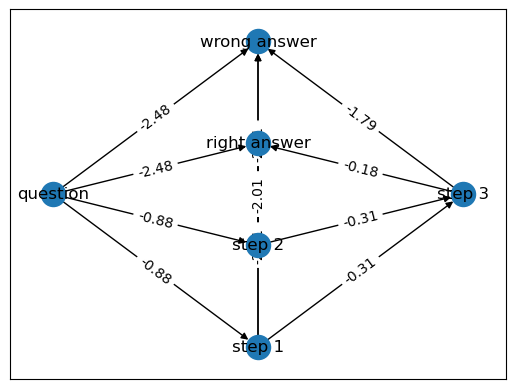

In [12]:
model = GroundTruthModel()
classes, wordings = get_all_transitions(model)
graph = build_probabilistic_graph(classes, wordings, model, 100)

# graph drawing things
pos = nx.bfs_layout(graph, start="question")
labels = dict()
for u, v, data in graph.edges(data=True):
    labels[(u, v)] = data["weight"]
fig, ax = plt.subplots()
nx.draw_networkx(graph, pos=pos, ax=ax)
nx.draw_networkx_edge_labels(graph, pos=pos, edge_labels=labels)
fig.savefig("example-plot.png")
